### Graph analysis

This script reads corelation matrices data na surrogate data and calculate modularity index of a graph
for each time condition separately, plot a thresholded graph, plot a correlation matrix, plot an adjacency
matrix and plot a bar graph representing changes of modularity index in time 

*Parameters to consider*:
- nC: a number of conditions per figure (should equal 1 in this version)
- nG: a number of groups
- nS: a number of subjects in a group
- nE: a number of electrodes in a subject
- scaler: a smart constatnt for scaling the subject positions to fit a nice shape
- treshZ - thresholding the z value correlation matrix for making a graph


*Inputs*:
- load the correlation matrix files *_true.npy (for true) and *_surr.npy (for surrpgates)
- load an electrode layout file ASA_standard_waveguard64_Layout_noMs.txt
- load a subject position file i.e. 1st_positions.npz
    
*Outputs*:
    save plots to the png images

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import os

def init_list(dims, val):
    if len(dims) == 0:
        raise ValueError("Requires at least 1 dimension.")
    if len(dims) == 1:
        return [val for _ in range(dims[0])]
    return [init_list(dims[1:], val=val) for _ in range(dims[0])]

inputPath = '/home/koudelka/Projects/AyahuascaMusic/input/'
outputPath = '/home/koudelka/Projects/AyahuascaMusic/output/'
pipePath = 'C:/FEL/ING/diplomka/data/TG/kamdu/'

nC = 3
nG = 1
nS = 2
nE = 64

pwd = os.getcwd()

corrMatObs = init_list((nC,nG),val=0)
corrMatSur = init_list((nC,nG),val=0)
for cIdx in range(0,nC):
    for gIdx in range(0,nG):
        corrMatObs[cIdx][gIdx] = np.load(pipePath + 'c' + str(cIdx) + 'g' + str(gIdx) + '_observed' + '.npy')
        corrMatSur[cIdx][gIdx] = np.load(pipePath + 'c' + str(cIdx) + 'g' + str(gIdx) + '_surrogate' + '.npy')       

### Compute the Modularity index, Average clustering, and Diameter
- the Z-values are used
- Z-value is obtained from relating the observed values (in corrMatObs) to the surrogate distribution (in corrMatSur) mean and variance
- Z-matrix is thresholded based on *treshZ* variable
- G object is created based on adjacency matrix
- modulation index is computed

In [11]:
treshZ = 2.5

modNx = init_list((nC,nG),val=0)
clustNx = init_list((nC,nG),val=0)
denseNx = init_list((nC,nG),val=0)
corrZ = init_list((nC,nG),val=0)
for cIdx in range(0,nC):
    for gIdx in range(0,nG):
        meanSurrMat = np.mean(corrMatSur[cIdx][gIdx],axis=0)
        stdSurrMat = np.std(corrMatSur[cIdx][gIdx],axis=0)

        corrZ[cIdx][gIdx] = np.divide(corrMatObs[cIdx][gIdx] - meanSurrMat,stdSurrMat)
        adjMat = corrZ[cIdx][gIdx]
        adjMat = (adjMat > treshZ) * adjMat
        adjMat = (adjMat > 0)

        
        
        G = nx.from_numpy_array(adjMat)

        commun = []
        for subIdx in range(0,nS):
            commun.append(np.arange(0,nE))
            commun[subIdx] =commun[subIdx]+subIdx*nE
        modNx[cIdx][gIdx] = nx.community.modularity(G,commun)
        clustNx[cIdx][gIdx] = nx.average_clustering(G)
        denseNx [cIdx][gIdx] = nx.density(G)
        
modNx = np.array(modNx)
clustNx = np.array(clustNx)
denseNx = np.array(denseNx)
corrZ = np.array(corrZ)

C:\Users\Martin\AppData\Local\Temp\ipykernel_8072\3406720318.py:12: RuntimeWarning: invalid value encountered in divide
  corrZ[cIdx][gIdx] = np.divide(corrMatObs[cIdx][gIdx] - meanSurrMat,stdSurrMat)


### Save the computed modularity index

In [4]:
np.save(outputPath + 'modularity_index', modNx)

### Plot the average modulatory index across groups between conditions

- this can be later used for printing boxplots or violin plots for example



Text(0.5, 1.0, 'Averaged density')

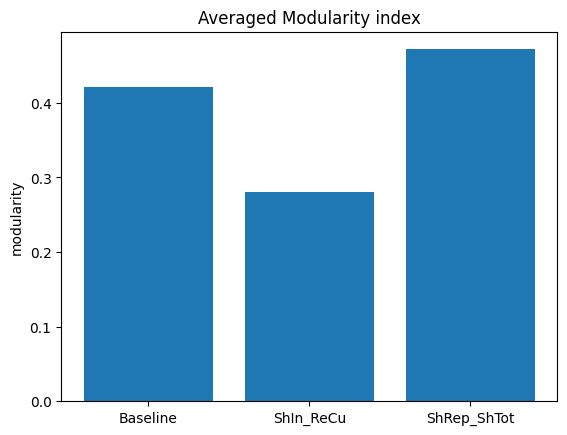

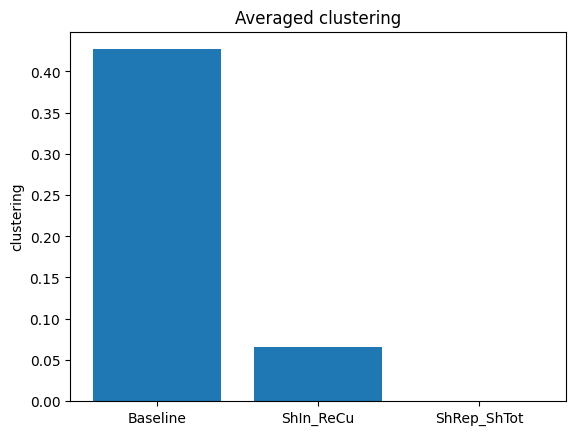

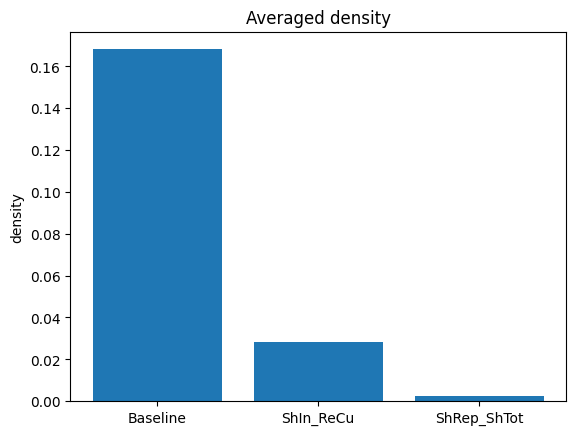

In [15]:
import matplotlib.pyplot as plt

condLab = ['Baseline','ShIn_ReCu', 'ShRep_ShTot']

avgMod = np.mean(modNx,axis=1)
plt.bar(condLab,avgMod)
plt.ylabel('modularity')
plt.title('Averaged Modularity index')

plt.figure()
avgClust = np.mean(clustNx,axis=1)
plt.bar(condLab,avgClust)
plt.ylabel('clustering')
plt.title('Averaged clustering')

plt.figure()
avgDense = np.mean(denseNx,axis=1)
plt.bar(condLab,avgDense)
plt.ylabel('density')
plt.title('Averaged density')


### Plot the averaged Z-correlation matrices
- the triangular submatrices on the diagonal corresponds to within subject connectivity
- of diagonal submatrices corresponds to inter subject connectivity

C:\Users\Martin\AppData\Local\Temp\ipykernel_8072\3974933257.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.2, 1, 0.9])  # Adjust to make room for colorbar


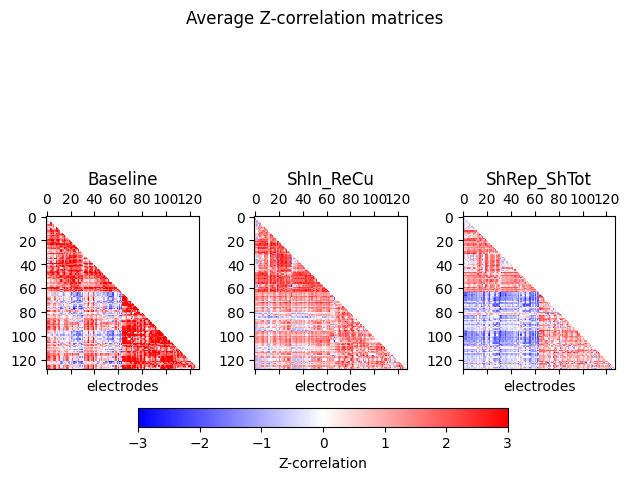

In [13]:
meanCorrZ = np.mean(corrZ,axis=1)

fig, ax = plt.subplots(1, nC)
fig.suptitle('Average Z-correlation matrices')

for cIdx in range(0,nC):
    im = ax[cIdx].matshow(meanCorrZ[cIdx,:,:],cmap = 'bwr',vmin=-3,vmax=3)
    ax[cIdx].set_title(condLab[cIdx])
    ax[cIdx].set_xlabel('electrodes')

cbar = fig.colorbar(im, ax=ax, orientation='horizontal', fraction=0.05, pad=0.2)
cbar.set_label('Z-correlation')
plt.tight_layout(rect=[0, 0.2, 1, 0.9])  # Adjust to make room for colorbar

array([[0.        , 0.97868438, 1.19543049, ..., 1.26960584, 1.03074281,
        2.05177715],
       [0.97868438, 0.        , 1.7957463 , ..., 0.79857974, 0.99718985,
        2.0268338 ],
       [1.19543049, 1.7957463 , 0.        , ..., 0.86892504, 0.81961994,
        2.02196393],
       ...,
       [1.26960584, 0.79857974, 0.86892504, ..., 0.        , 1.65590649,
        0.92134849],
       [1.03074281, 0.99718985, 0.81961994, ..., 1.65590649, 0.        ,
        1.3780023 ],
       [2.05177715, 2.0268338 , 2.02196393, ..., 0.92134849, 1.3780023 ,
        0.        ]])

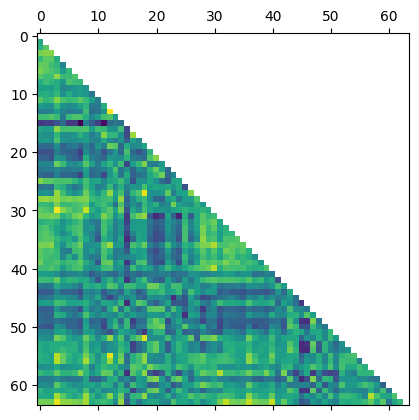

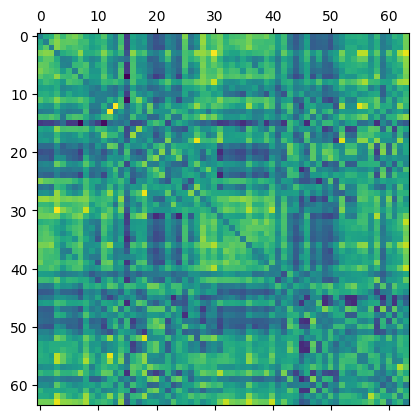

In [8]:
testMat = meanCorrZ[cIdx,:,:]
plt.matshow(testMat)
testMat[np.isnan(testMat)] = 0
syMat = testMat + testMat.T #- np.diag(np.diag(testMat))
plt.matshow(syMat)  
syMat                               